## Processing FVCOM for 1km Regular Grid

For the river plume feature engineering work we wan't to use FVCOM data as a validation dataset. To make the validation easier, the FVCOM data needs to be interpolated/regrid to a new regular grid.

In [4]:
import xarray as xr
import pandas as pd
import os
#import netcdf4
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
from pyproj import Transformer
import numpy as np
from tqdm import tqdm
from scipy.spatial import Delaunay
#import xesmf as xe
import rioxarray
from shapely.geometry import Polygon
from matplotlib.path import Path
import geopandas as gpd
import matplotlib.pyplot as plt


# Path to Box Assets
box_root = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lob_ecol_path = f"{box_root}Mills Lab/Projects/Lobster ECOL"
fvcom_path = f"{box_root}RES_Data/FVCOM/Lobster-ECOL/"

# Option 1: Load the Point/Index Key

One way to achieve this is to perform linear interpolations manually for each new grid-center location from a regular 1km grid.

The following table provides the details on which FVCOM nodes are needed to interpolate at each 1km grid cell. It was created by taking a regularly spaced 1km rectangualr grid, and overlaying the center coordinates onto the FVCOM mesh. Mesh element and the nearest nodes associated with each grid center `lon` and `lat` coordinates were added to this table. I also added the weights for each node to perform linear-weighting interpolation .

This table should let me go through each row, and store the interpolated timeseries (somewhere) in an organized way.

In [5]:
# Path to local assets:
local_path = "/Users/adamkemberling/Documents/Repositories/Lobster-ECOL/"
grid_pts = pd.read_csv(f"{local_path}local_data/plumes/grid_1km_fvcom_indices.csv")
grid_pts.head()

,lon,lat,elem,p1,p2,p3,p1_wt,p2_wt,p3_wt
0,-71.9955,41.1545,50703,25841,25534,25842,0.391726,0.143350,0.464924
1,-71.9865,41.1545,50703,25841,25534,25842,0.807151,0.142960,0.049888
2,-71.9775,41.1545,50701,25532,25533,25841,0.231433,0.153118,0.615449
3,-71.9685,41.1545,50701,25532,25533,25841,0.644348,0.164525,0.191127
4,-71.9595,41.1545,50105,25532,25230,25231,0.764137,0.034938,0.200925


## Local FVCOM Data Inventory

For convenience, surface and bottom temperature and surface currents were obtained via direct-request from the Chen lab as a standalone product. 

This data is available in the GOM3 grid from 1978-2019 for surface and bottom temperatures, and surface currents.

For processing salinity, we will need to use the THREDDS endpoints. But for now, and for certain tasks, we can use these files to make our lives much easier.

In [6]:
# Path to xarray files on box
os.listdir(fvcom_path)

# Load the annual files for oisst
fpaths = []
for yr in range(1979, 2019 + 1):
    fpaths.append(f'{fvcom_path}gom3_{yr}.nc')

## Working with Online FVCOM

We need surface salinity, which is not something that we requested. For these we want to reach for the Seaplan Hindcast Daily Averages

In [7]:
# This is one way to open a file download url, but it loads everything into memory
# ds_thredds = xr.open_dataset(
#     "http://www.smast.umassd.edu:8080/thredds/fileServer/models/fvcom/NECOFS/Archive/Seaplan_33_Hindcast_v1/daily_mean/gom3_daily_mean_201101.nc#mode=bytes",
#     decode_times=False)
# ds_thredds

In [8]:

# This is another way to open a file via the OPeNDAP url, which does not load everything into memory

# Path to seaplan catalog (where we can see all the files available):
# http://www.smast.umassd.edu:8080/thredds/catalog/models/fvcom/NECOFS/Archive/Seaplan_33_Hindcast_v1/catalog.html

# NECOFS hindcast data (2016-present, as hourly data) is available at:
#base_url = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/"

# Link to the Seaplan 33 Hindcast (1978-2019 data)
base_daily_url = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/Seaplan_33_Hindcast_v1/daily_mean"



# Generate all the URLs with a good old fashioned loop:

# Basic Structures for the year and month components
all_months = np.arange(1,13)
all_years = np.arange(2011,2017, 1)
daily_thredds_urls = []
for yr in all_years:
    yr_base = f"{base_daily_url}/gom3_daily_mean_{yr}"
    
    for mon in all_months:
        yr_mon_ext = f"{yr_base}{mon:02d}.nc"
        daily_thredds_urls.append(yr_mon_ext)


# Peak at the first few URLS
daily_thredds_urls[0:2]

# # Open one
ds_thredds = xr.open_dataset(daily_thredds_urls[0],decode_times=False)
ds_thredds

<xarray.Dataset> Size: 2GB
Dimensions:        (nele: 90415, node: 48451, siglay: 45, siglev: 46, three: 3,
                    time: 31, maxnode: 11, maxelem: 9, four: 4)
Coordinates:
    x              (node) float32 194kB ...
    y              (node) float32 194kB ...
    siglay         (siglay, node) float32 9MB ...
    siglev         (siglev, node) float32 9MB ...
  * time           (time) float32 124B 5.556e+04 5.556e+04 ... 5.559e+04
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four
Data variables: (12/40)
    nprocs         int32 4B ...
    partition      (nele) int32 362kB ...
    lon            (node) float32 194kB ...
    lat            (node) float32 194kB ...
    xc             (nele) float32 362kB ...
    yc             (nele) float32 362kB ...
    ...             ...
    temp           (time, siglay, node) float32 270MB ...
    salinity       (time, siglay, node) float32 270MB ...
    short_wave     (time, node) float32 6MB ...
    net_heat_flux  (time, node) float32 6MB ...
    precip         (time, node) float32 6MB ...
    evap           (time, node) float32 6MB ...
Attributes: (12/17)
    title:                           GOM3 Hindcast  by yf.sun@umassd.edu and ...
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         model started at: 19/11/2018   20:25
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Surface_Heat_Forcing:            FVCOM variable surface heat forcing file...
    Surface_Wind_Forcing:            FVCOM variable surface Wind forcing:\nFI...
    Surface_PrecipEvap_Forcing:      FVCOM periodic surface precip forcing:\n...
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

## Subsetting with Area-Clipped Indexing Information

For any of the FVCOM files that we don't have locally, a known challenge will be getting down the data without the servers crashing. 

There is a size limit og 1GB downloads, so we need to stay under that.

To minimize the data we're pulling down from online, we can use node and element indexes directly from the dataframe we made in R that clipped the mesh to our study area:

In [9]:
# Unique Nodes and elements from our area of interest
node_ids = pd.melt(grid_pts.drop(columns = ["lon", "lat", "elem", "p1_wt", "p2_wt","p3_wt"]))["value"].unique()
elem_ids = grid_pts["elem"].unique()
py_node_ids = node_ids -1
py_elem_ids = elem_ids - 1

In [10]:
# Use a local one for now...
test_ds = xr.open_dataset(fpaths[10])

# Subset Check The nodes, elements, variables
#variables = ["surface_t", "bottom_t", "surface_u", "surface_v"]
trim_test = test_ds.isel(
    node = py_node_ids, 
    nele = py_elem_ids)#[variables]


### Plotting Clipped Coordinate Maps

Text(0.5, 1.0, 'Bottom Temp')

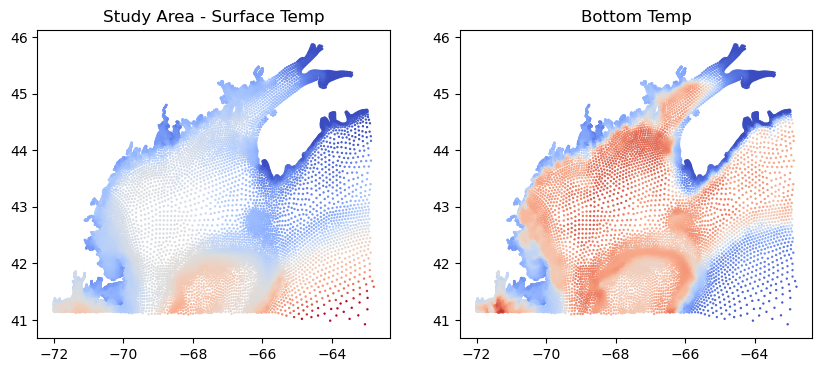

In [11]:
# Plot the temperatures at the node coordinates
# Just grab the coordinates, tired of the dataset baggage
lon_vals = trim_test.isel(time = 0).lon.values
lat_vals = trim_test.isel(time = 0).lat.values


fig, ax = plt.subplots(1,2, figsize=(10, 4))  # Create a figure containing a single axes.
ax[0].scatter(x = lon_vals, y = lat_vals,  c = trim_test.surface_t.isel(time = 0), s = .5, cmap = "coolwarm", vmin = 2, vmax = 10)
ax[0].set_title("Study Area - Surface Temp")  # Add a title to the axes.
ax[1].scatter(x = lon_vals, y = lat_vals,  c = trim_test.bottom_t.isel(time = 0), s = .5, cmap = "coolwarm", vmin = 2, vmax = 10)
ax[1].set_title("Bottom Temp")  # Add a title to the axes.


## NOT USED: Aggregating Hourly to Daily

For years before 2011 the data is no longer available in the catalog and would need to be aggregated. Here is what that would look like:

This takes a very long time over the THREDDS connection, and should be avoided if possible.

In [12]:
# from dateutil import parser
# from datetime import datetime,timedelta

# # Path to Hourly Data
# hourly_fvcom_path = f"http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/Seaplan_33_Hindcast_v1"

# # Load the hourly data
# ds_hourly = xr.open_dataset(
#     f"{hourly_fvcom_path}/gom3_200401.nc",
#     decode_times=False)

# # Decode Times variable to strings
# times_str = [''.join(t.astype(str)).strip() for t in ds_hourly['Times'].values]

# # Parse to datetime objects
# times_dt = [parser.parse(t) for t in times_str]

# # Assign as a new coordinate
# ds_hourly = ds_hourly.assign_coords(time=("time", times_dt))

# # Subset Check The nodes, elements, variables
# variables = ["Times", "lon", "lat", "salinity"]
# hourly_trim = ds_hourly.isel(
#     node = py_node_ids, 
#     nele = py_elem_ids,
#     siglay = 0)[variables]

# # Resample to daily
# as_daily = hourly_trim.resample(time = "1D").mean()
# as_daily

# # Plot the salinity at the node coordinates
# lon_vals = as_daily.isel(Times = 0).lon.values
# lat_vals = as_daily.isel(Times = 0).lat.values
# fig, ax = plt.subplots(1,1, figsize=(10, 4))  # Create a figure containing a single axes.       
# ax.scatter(x = lon_vals, y = lat_vals,  c = as_daily.salinity.isel(Times = 0), s = .5, cmap = "coolwarm", vmin = 2, vmax = 10)
# ax.set_title("Study Area - Salinity")  # Add a title to the axes.

----
# Workflow Testing: 
## Interpolation Method 1: LinearNDInterpolator

This approach uses scipy.interpolate's LinearNDInterpolator to interpolate arrays for each variable to the new grid. It operates by linear-interpolation via barycentric coordinates, taking information from the three nodes that an interpolation point falls between.

This approach will interpolate beyond the actual FVCOM mesh if interpolation points lie within the broad area and can be triangulated. This can be resolved by adding a masking step and making these values beyond the original mesh NaN's. Within the actual mesh, results are what we are looking for so this approach will work as intended.

It works fine, just takes some time.

The workflow would be to loop over files, and save each year out again as its own file.



### Grid Setup Option 1: Making an Actual 1km Grid

The following chunk below uses a projected CRS in meters to create a more precise 1km grid. After making it, I don't feel like its that critical for our application, and I've opted for a simpler code and a neater output when visually displayed by staying in crs:4326.

In [13]:
# # Desired lat/lon bounding box
# bbox = {
#     "xlims": (-72.973, -60.969),  # lon_min, lon_max
#     "ylims": (40.683, 45.315)     # lat_min, lat_max
# }

# # Create transformer from lat/lon to EPSG:32619 (UTM zone 19N)
# transformer = Transformer.from_crs("EPSG:4326", "EPSG:32619", always_xy=True)


# # Define 1km grid over the extent of the bbox
# xmin, ymin = transformer.transform(bbox["xlims"][0], bbox["ylims"][0])
# xmax, ymax = transformer.transform(bbox["xlims"][1], bbox["ylims"][1])

# grid_x, grid_y = np.meshgrid(
#     np.arange(xmin, xmax, 1000),
#     np.arange(ymin, ymax, 1000)
#     )
# ny, nx = grid_x.shape


### Grid Setup Option 2: Making a ~1km Mesh from BBOX

A bounding box with general bounding coordinates from long island to New Brunswick is set up below. I am using this area and creating an evenly spaced rectangular grid to use as the destination frid for the interpolation/regridding.

In [14]:
# Or just eyeball it
# ~1km resolution in degrees (~0.009 degrees)
res_deg = 0.009

# Desired lat/lon bounding box
bbox = {
    "xlims": (-72, -63),  # lon_min, lon_max
    "ylims": (41.15, 46)     # lat_min, lat_max
}

# Make new grid
lon_new = np.arange(bbox["xlims"][0], bbox["xlims"][1], res_deg)
lat_new = np.arange(bbox["ylims"][0], bbox["ylims"][1], res_deg)
grid_x, grid_y = np.meshgrid(lon_new, lat_new)

# Sizes
ny, nx = grid_x.shape

## Workflow Testing: Load an FVCOM file for Mesh Coordinates to Trim With

One of the first steps for this whole thing is to load a file and pull the mesh coordinates we will be using for everything downstream.

This is the point where we could trim the mesh down.

In [15]:
# Load one FVCOM output
ds = xr.open_dataset(fpaths[0])
nt = ds.sizes["time"] # number of time steps

# Trim to study area
ds = ds.isel(
    node = py_node_ids, 
    nele = py_elem_ids)

# Pull mesh coordinates
lon_nodes = ds['lon'].values
lat_nodes = ds['lat'].values
lon_centers = ds['lonc'].values
lat_centers = ds['latc'].values

# # Project node and center coordinates
# x_nodes, y_nodes = transformer.transform(lon_nodes, lat_nodes)
# x_centers, y_centers = transformer.transform(lon_centers, lat_centers)

# Or don't if we're staying in 4326
x_nodes = lon_nodes
y_nodes = lat_nodes
x_centers = lon_centers
y_centers = lat_centers

## Workflow Testing: Masking with Mesh Polygon

In R I created a study-area polygon that follows the coastal contours of the FVCOM mesh by doing a geometry union of the GOM3 mesh itself. This polygon can be used as a land-mask, which will be to used after interpolation to mask out values on land between the many inlets/bays up and down the coast.

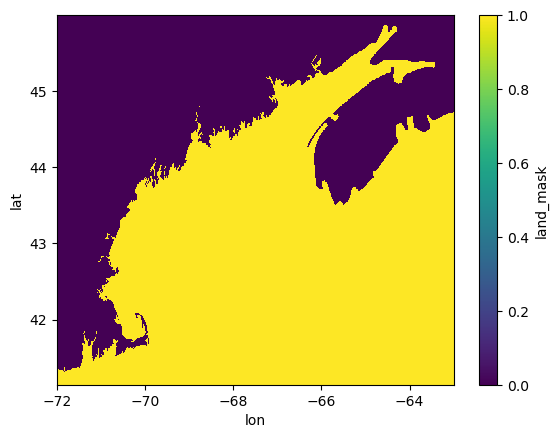

In [16]:
# Determine whether things are in/out


# Use the actual mesh as the inside/outside mask

gom3_mesh = gpd.read_file(f"{local_path}local_data/mesh_shapefiles/gom3_mesh.geojson")
gom3_hull = gpd.read_file(f"{local_path}local_data/mesh_shapefiles/gom3_mesh_hull.geojson")

# If it's just one feature:
polygon = gom3_hull.geometry.values[0]

# Get the destination points as pairs for interpolation
# Flatten the grid to Nx2 points (as (lon, lat))
interp_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

# Create a Path from the polygon exterior
path = Path(np.array(polygon.exterior.coords))

# Mask: True if point is inside the polygon
inside_mask = path.contains_points(interp_points)

# Reshape to match grid shape
mask = inside_mask.reshape(grid_x.shape)

# Convert to dataarray 
mask_ds = xr.Dataset(
    coords=dict(
        lon = (["lat", "lon"], grid_x),
        lat = (["lat", "lon"], grid_y)
    ),
    data_vars = dict(
        land_mask = (["lat", "lon"], mask)
    ),
    attrs={"crs": "EPSG:4326"})

# Plot to check the mask
mask_ds.land_mask.plot()

## Workflow Testing: Preparing Arrays, Loop Every Timestep

Next up, pre-allocate memory for an empty array for each of the vars we're interpolating.

At each timestep, linearNDinterpolator pulls out variables we care about as an array and interpolates them to the new coordinates.

In [ ]:
# # Automatically do nt
# #nt = ds.sizes["time"] # number of time steps

# # Manually adjust NT
# nt = 10
# sst_all = np.full((nt, ny, nx), np.nan)
# bt_all  = np.full((nt, ny, nx), np.nan)
# u_all   = np.full((nt, ny, nx), np.nan)
# v_all   = np.full((nt, ny, nx), np.nan)

# # Loop over time and interpolate each timestep
# for i in tqdm(range(nt), desc = "Interpolating timesteps"):
    
#     # Pull Node values for that time step, interpolate to new grid
#     # SST + BT
#     sst_vals = ds['surface_t'].isel(time=i).values
#     bt_vals  = ds['bottom_t'].isel(time=i).values
#     sst_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), sst_vals)
#     bt_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), bt_vals)
    
#     # Same for u and v, using x_centers/y_centers:
#     u_vals = ds['surface_u'].isel(time=i).values
#     v_vals = ds['surface_v'].isel(time=i).values
#     u_interp = LinearNDInterpolator(np.column_stack((x_centers, y_centers)), u_vals)
#     v_interp = LinearNDInterpolator(np.column_stack((x_centers, y_centers)), v_vals)

#     sst_all[i] = sst_interp(interp_points).reshape(grid_x.shape)
#     bt_all[i]  = bt_interp(interp_points).reshape(grid_x.shape)
#     u_all[i]   = u_interp(interp_points).reshape(grid_x.shape)
#     v_all[i]   = v_interp(interp_points).reshape(grid_x.shape) 


Interpolating timesteps: 100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


### Workflow Testing: Assemble Everything as an xarray Dataset

Once we have the arrays for the different variables, we can assemble the xr.Dataset and prepare it for masking and exporting.

This is also where we can add the metadata needed for the coordinate reference system to export with the netcdf.

In [ ]:
# # Build output dataset - lat and lon coordinates
# ds_interp = xr.Dataset(
#     coords=dict(
#         time = ds['time'].values[0:nt],
#         lon = (["lat", "lon"], grid_x),
#         lat = (["lat", "lon"], grid_y)
#     ),
#     data_vars=dict(
#         surface_t = (["time", "lat", "lon"], sst_all),
#         bottom_t = (["time", "lat", "lon"], sst_all),
#         surface_u = (["time", "lat", "lon"], u_all),
#         surface_v = (["time", "lat", "lon"], v_all)
#     ),
#     attrs={"crs": "EPSG:4326"})

# # # Apply the mask
# land_mask = mask_ds['land_mask']
# ds_interp = ds_interp.where(land_mask)

# #=== For CRS to export===

# # Step 1: Create CRS metadata variable
# crs_var = xr.DataArray(
#     0,
#     attrs={
#         "grid_mapping_name": "latitude_longitude",
#         "epsg_code": "EPSG:4326",
#         "semi_major_axis": 6378137.0,
#         "inverse_flattening": 298.257223563
#     })

# # Assign crs
# ds_interp["crs"] = crs_var

# # Step 2: Add grid_mapping attribute to each relevant variable
# # Add grid_mapping attribute to each data variable
# for var in ["surface_t", "bottom_t", "surface_u", "surface_v"]:
#     ds_interp[var].attrs["grid_mapping"] = "crs"

# # Step 3: Add standard_name and units to coordinates
# ds_interp["lon"].attrs.update({
#     "standard_name": "longitude",
#     "units": "degrees_east",
#     "axis": "X"
# })
# ds_interp["lat"].attrs.update({
#     "standard_name": "latitude",
#     "units": "degrees_north",
#     "axis": "Y"
# })


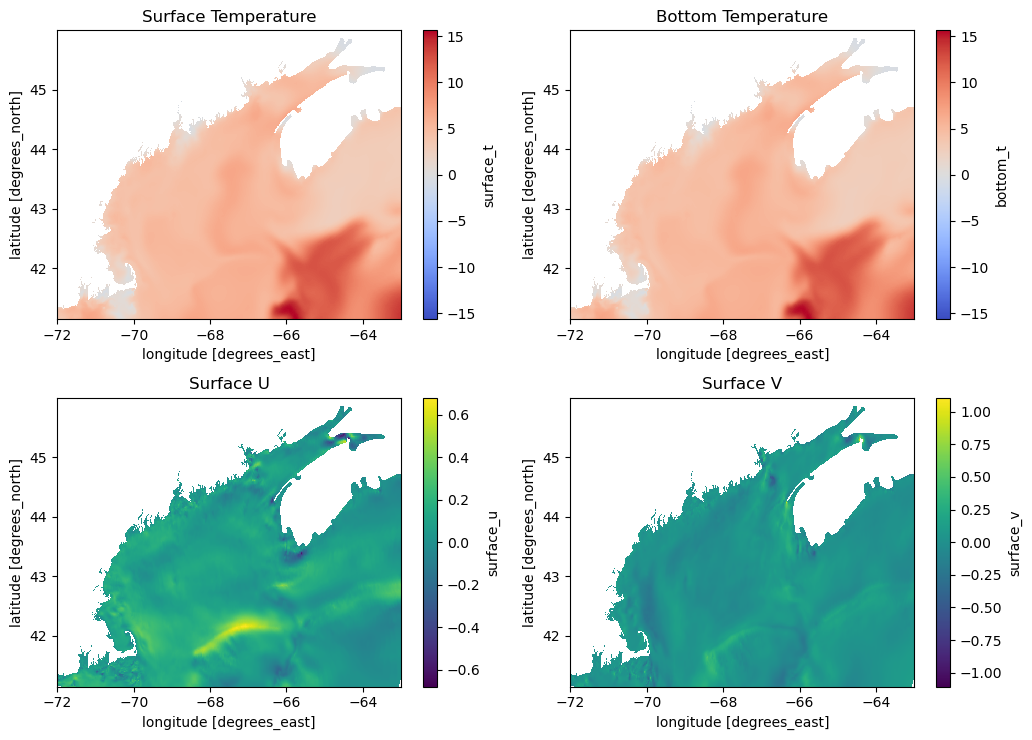

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10.5, 7.5))

# Plot surface_t
ds_interp.surface_t.isel(time=0).plot(ax=axes[0, 0], cmap="coolwarm")
axes[0, 0].set_title("Surface Temperature")

# Plot bottom_t
ds_interp.bottom_t.isel(time=0).plot(ax=axes[0, 1], cmap="coolwarm")
axes[0, 1].set_title("Bottom Temperature")

# Plot surface_u
ds_interp.surface_u.isel(time=0).plot(ax=axes[1, 0], cmap="viridis")
axes[1, 0].set_title("Surface U")

# Plot surface_v
ds_interp.surface_v.isel(time=0).plot(ax=axes[1, 1], cmap="viridis")
axes[1, 1].set_title("Surface V")

plt.tight_layout()
plt.show()

### Workflow Testing: Building Paths for Exporting

We want somewhere to put these so my computer does not blow up.

In [ ]:
# # Build path to save it somewhere

# # out_path = f"{local_path}local_data/plumes/1km_grid_data/"
# out_path = f"{local_path}local_data/plumes/"
# out_name = fpaths[0].replace(fvcom_path, "").replace(".nc", "")
# print(f"Saving file for {out_name}")
# out_name = f"{out_path}{out_name}_1kmgrid_surface_daily.nc"

# # Export:
# ds_interp.to_netcdf(out_name)

Saving file for gom3_1979


---

# Running the Set:

## Applying the Approach to Many files:

The steps that don't need to loop:
 * creating the output grid
 * creating the mask

The steps that will be looped over:
 * Open a netcdf
 * Populate empty arrays
 * Interpolate each variable
 * Reassemble a dataset
 * Appky land mask
 * Export



In [ ]:
# Get the subset of fpaths to loop through
felipe_years = [str(y) for y in range(1992, 2020)]

# Pull the local paths that match those years
felipe_fpaths = [f for f in fpaths if any(year in f for year in felipe_years)]
felipe_fpaths[-1]

'/Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/FVCOM/Lobster-ECOL/gom3_2019.nc'

In [25]:
# # Loop 1990-2019 - Local Data, no siglev, no salinity
# for file in felipe_fpaths:
# # for file in short_fpaths:
    
#     # Read the file:
#     ds_x = xr.open_dataset(file)

#     # Trim to study area
#     ds_x = ds_x.isel(
#         node = py_node_ids, 
#         nele = py_elem_ids)
    
#     # Preallocate output arrays with nans
#     sst_all = np.full((nt, ny, nx), np.nan)
#     bt_all  = np.full((nt, ny, nx), np.nan)
#     u_all   = np.full((nt, ny, nx), np.nan)
#     v_all   = np.full((nt, ny, nx), np.nan)
    
#     # Loop over time and interpolate each timestep
#     nt = ds_x.sizes["time"] # number of time steps
#     for i in tqdm(range(nt), desc = "Interpolating timesteps"):
        
#         # Pull Node values for that time step, interpolate to new grid
#         # SST + BT
#         sst_vals = ds_x['surface_t'].isel(time=i).values
#         bt_vals  = ds_x['bottom_t'].isel(time=i).values
#         sst_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), sst_vals)
#         bt_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), bt_vals)
        
#         # Same for u and v, using x_centers/y_centers:
#         u_vals = ds_x['surface_u'].isel(time=i).values
#         v_vals = ds_x['surface_v'].isel(time=i).values
#         u_interp = LinearNDInterpolator(np.column_stack((x_centers, y_centers)), u_vals)
#         v_interp = LinearNDInterpolator(np.column_stack((x_centers, y_centers)), v_vals)

#         sst_all[i] = sst_interp(interp_points).reshape(grid_x.shape)
#         bt_all[i]  = bt_interp(interp_points).reshape(grid_x.shape)
#         u_all[i]   = u_interp(interp_points).reshape(grid_x.shape)
#         v_all[i]   = v_interp(interp_points).reshape(grid_x.shape) 

# # Build output dataset - lat and lon coordinates
# ds_interp = xr.Dataset(
#     coords=dict(
#         time = ds['time'].values,
#         lon = (["lat", "lon"], grid_x),
#         lat = (["lat", "lon"], grid_y)
#     ),
#     data_vars=dict(
#         surface_t = (["time", "lat", "lon"], sst_all),
#         bottom_t = (["time", "lat", "lon"], bt_all),
#         surface_u = (["time", "lat", "lon"], u_all),
#         surface_v = (["time", "lat", "lon"], v_all)
#     ),
#     attrs={"crs": "EPSG:4326"})

# # # Apply the mask
# land_mask = mask_ds['land_mask']
# ds_interp = ds_interp.where(land_mask)

# #=== For CRS to export===

# # Step 1: Create CRS metadata variable
# crs_var = xr.DataArray(
#     0,
#     attrs={
#         "grid_mapping_name": "latitude_longitude",
#         "epsg_code": "EPSG:4326",
#         "semi_major_axis": 6378137.0,
#         "inverse_flattening": 298.257223563
#     })

# # Assign crs
# ds_interp["crs"] = crs_var

# # Step 2: Add grid_mapping attribute to each relevant variable
# # Add grid_mapping attribute to each data variable
# for var in ["surface_t", "bottom_t", "surface_u", "surface_v"]:
#     ds_interp[var].attrs["grid_mapping"] = "crs"

# # Step 3: Make sure coordinates have standard_name attributes
# ds_interp["lon"].attrs["standard_name"] = "longitude"
# ds_interp["lat"].attrs["standard_name"] = "latitude"

# # Optional: CF-compliant units
# ds_interp["lon"].attrs["units"] = "degrees_east"
# ds_interp["lat"].attrs["units"] = "degrees_north"
# ds_interp["lon"].attrs["axis"] = "X"
# ds_interp["lat"].attrs["axis"] = "Y"

# # Build path to save it somewhere
# out_path = f"{local_path}local_data/plumes/1km_grid_data/"
# out_name = file.replace(fvcom_path, "").replace(".nc", "")
# print(f"Saving file for {out_name}")
# out_name = f"{out_path}{out_name}_1kmgrid_surface_daily.nc"

# # Export:
# ds_masked.to_netcdf(out_name)

---
# Using Available Daily THREDDS Hindcasts

### Running Daily Salinities

There are some files online that are available for download. Its not the full range of years, but its a starting point:

# Repeating the Process with THREDDS Data for Salinity

Felipe only really wants salinity, and there are some years available as monthly files. I can process these while we wait on the full data:

# Looping over Available Daily Files

In [1]:
# Files will look like this:
xr.open_dataset(daily_thredds_urls[0], decode_times = False)


NameError: name 'xr' is not defined

### Testing/timing one file:

This is taking quite a bit of time...

In [ ]:
# Test for one of these files:
ds_test = xr.open_dataset(daily_thredds_urls[0], decode_times = False)

# Get the number of time steps
nt = ds_test["Times"].size # number of time steps

# Trim to study area
ds_test = ds_test.isel(
    node = py_node_ids, 
    nele = py_elem_ids)
    
# Preallocate output arrays with nans with for the area and time
sss_all = np.full((nt, ny, nx), np.nan)
#bs_all  = np.full((nt, ny, nx), np.nan)

# Loop over time and interpolate each timestep
# Pull Node values for that time step, interpolate to new grid
for i in tqdm(range(nt), desc = "Interpolating timesteps"):

        # Salinity
        sss_vals = ds_test['salinity'].isel(time=i, siglay = 0).values
        #bs_vals  = ds_test['salinity'].isel(time=i, siglay = -1).values

        # Create interpolators
        sss_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), sss_vals)
        #bs_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), bs_vals)

        # Reshape and assign
        sss_all[i] = sss_interp(interp_points).reshape(grid_x.shape)
        #bs_all[i]  = bs_interp(interp_points).reshape(grid_x.shape)


# Build output dataset - using lat and lon coordinates
ds_interp = xr.Dataset(
    coords = dict(
        time = ds_test['Times'].values,
        lon = (["lat", "lon"], grid_x),
        lat = (["lat", "lon"], grid_y)),
    data_vars = dict(
        surface_salinity = (["time", "lat", "lon"], sss_all)#,
        #bottom_salinity = (["time", "lat", "lon"], bs_all)),
    attrs = {"crs": "EPSG:4326"})

# # Apply the mask
land_mask = mask_ds['land_mask']
ds_interp = ds_interp.where(land_mask)
ds_interp
    

Interpolating timesteps:  13%|█▎        | 4/31 [1:16:26<8:51:53, 1181.99s/it]

In [ ]:
# Plot to check
ds_interp.surface_salinity.isel(time=0).plot(cmap="viridis")

## Running the Whole Set

In [ ]:
# Loop 2011-2016 - Online Daily Data, pull top siglev for salinity
for file in daily_thredds_urls:
# for file in daily_thredds_urls[0:2]:
    
    # Read the file:
    ds_x = xr.open_dataset(file, decode_times=False)

    # Trim to study area
    ds_x = ds_x.isel(
        node = py_node_ids, 
        nele = py_elem_ids)
    
    # Preallocate output arrays with nans
    # sst_all = np.full((nt, ny, nx), np.nan)
    # bt_all  = np.full((nt, ny, nx), np.nan)
    sss_all = np.full((nt, ny, nx), np.nan)
    bs_all  = np.full((nt, ny, nx), np.nan)
    # u_all   = np.full((nt, ny, nx), np.nan)
    # v_all   = np.full((nt, ny, nx), np.nan)

    
    # Loop over time and interpolate each timestep
    nt = ds_x["Times"].size # number of time steps
    for i in tqdm(range(nt), desc = "Interpolating timesteps"):
        
        # Pull Node values for that time step, interpolate to new grid
        
        # # Temperature
        # sst_vals = ds_x['temp'].isel(time=i, siglay = 0).values
        # bt_vals  = ds_x['temp'].isel(time=i, siglay = -1).values
        # sst_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), sst_vals)
        # bt_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), bt_vals)

        # Salinity
        sss_vals = ds_x['salinity'].isel(time=i, siglay = 0).values
        bs_vals  = ds_x['salinity'].isel(time=i, siglay = -1).values
        sss_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), sss_vals)
        bs_interp = LinearNDInterpolator(np.column_stack((x_nodes, y_nodes)), bs_vals)
        
        # # Same for u and v, using x_centers/y_centers:
        # u_vals = ds_x['u'].isel(time=i, siglay = 0).values
        # v_vals = ds_x['v'].isel(time=i, siglay = 0).values
        # u_interp = LinearNDInterpolator(np.column_stack((x_centers, y_centers)), u_vals)
        # v_interp = LinearNDInterpolator(np.column_stack((x_centers, y_centers)), v_vals)

        # Reshape and assign
        # sst_all[i] = sst_interp(interp_points).reshape(grid_x.shape)
        # bt_all[i]  = bt_interp(interp_points).reshape(grid_x.shape)
        sss_all[i] = sss_interp(interp_points).reshape(grid_x.shape)
        bs_all[i]  = bs_interp(interp_points).reshape(grid_x.shape)
        # u_all[i]   = u_interp(interp_points).reshape(grid_x.shape)
        # v_all[i]   = v_interp(interp_points).reshape(grid_x.shape) 




# Build output dataset - using lat and lon coordinates
ds_interp = xr.Dataset(
    coords=dict(
        time = ds_x['Times'].values,
        lon = (["lat", "lon"], grid_x),
        lat = (["lat", "lon"], grid_y)
    ),
    data_vars=dict(
        # surface_temperature = (["time", "lat", "lon"], sst_all),
        # bottom_temperature = (["time", "lat", "lon"], bt_all),
        surface_salinity = (["time", "lat", "lon"], sss_all),
        bottom_salinity = (["time", "lat", "lon"], bs_all)#,
        # surface_u = (["time", "lat", "lon"], u_all),
        # surface_v = (["time", "lat", "lon"], v_all)
    ),
    attrs={"crs": "EPSG:4326"})

# # Apply the mask
land_mask = mask_ds['land_mask']
ds_interp = ds_interp.where(land_mask)

#=== For CRS to export===

# Step 1: Create CRS metadata variable
crs_var = xr.DataArray(
    0,
    attrs={
        "grid_mapping_name": "latitude_longitude",
        "epsg_code": "EPSG:4326",
        "semi_major_axis": 6378137.0,
        "inverse_flattening": 298.257223563
    })

# Assign crs
ds_interp["crs"] = crs_var

# Assign CRS to the regridded Dataset/DataArray
ds_interp.rio.write_crs("EPSG:4326", inplace=True)

# Step 2: Add grid_mapping attribute to each relevant variable
# Add grid_mapping attribute to each data variable
# for var in ["surface_temperature", "bottom_temperature", "surface_salinity", "bottom_salinity", "surface_u", "surface_v"]:
for var in ["surface_salinity", "bottom_salinity"]:
    ds_interp[var].attrs["grid_mapping"] = "crs"

# Step 3: Make sure coordinates have standard_name attributes
ds_interp["lon"].attrs["standard_name"] = "longitude"
ds_interp["lat"].attrs["standard_name"] = "latitude"

# Optional: CF-compliant units
ds_interp["lon"].attrs["units"] = "degrees_east"
ds_interp["lat"].attrs["units"] = "degrees_north"
ds_interp["lon"].attrs["axis"] = "X"
ds_interp["lat"].attrs["axis"] = "Y"

# Build path to save it somewhere
out_path = f"{local_path}local_data/plumes/1km_grid_salinity/"
out_name = file.replace(f"{base_daily_url}/gom3_daily_mean_", "").replace(".nc", "")
print(f"Saving file for {out_name}")
out_name = f"{out_path}{out_name}_1kmgrid_surface_daily.nc"

# Export:
ds_masked.to_netcdf(out_name)


Interpolating timesteps:   0%|          | 0/31 [00:00<?, ?it/s]Error:curl error: Timeout was reached
curl error details: 
Error:curl error: Timeout was reached
curl error details: 
Error:curl error: Timeout was reached
curl error details: 
Error:curl error: Timeout was reached
curl error details: 
Error:curl error: Timeout was reached
curl error details: 
Error:curl error: Timeout was reached
curl error details: 
Error:curl error: Timeout was reached
curl error details: 
Interpolating timesteps:   0%|          | 0/31 [5:32:42<?, ?it/s]


RuntimeError: NetCDF: I/O failure

----

## XESMF

Probably the best approach (for future me) would be to use XESMF to produce a regridder which could be applied to everything.

I don't think I have the time/attention to do this now, but flagging it.


This next chunk will create a mesh that is more accurately 1km, but will warp from the back and forth projections

In [10]:
# # Desired lat/lon bounding box
# bbox = {
#     "xlims": (-72.973, -60.969),  # lon_min, lon_max
#     "ylims": (40.683, 45.315)     # lat_min, lat_max
# }

# # Create transformer from lat/lon to EPSG:32619 (UTM zone 19N)
# transformer = Transformer.from_crs("EPSG:4326", "EPSG:32619", always_xy=True)

# # Define 1km grid over the extent of the bbox
# xmin, ymin = transformer.transform(bbox["xlims"][0], bbox["ylims"][0])
# xmax, ymax = transformer.transform(bbox["xlims"][1], bbox["ylims"][1])

# # Make the meshgrid
# grid_x, grid_y = np.meshgrid(
#     np.arange(xmin, xmax, 1000),
#     np.arange(ymin, ymax, 1000)
#     )

# # Add Lon and Lat Back in original CRS
# x_flat = grid_x.ravel()
# y_flat = grid_y.ravel()
# lon_grid, lat_grid = transformer.transform(x_flat, y_flat, direction='INVERSE')

# # Get them back in 4326 coordinates

# # Make it an xarray dataset
# target_grid = xr.Dataset({
#     "lon": (["lat", "lon"], lon_grid.reshape(grid_x.shape)),
#     "lat": (["lat", "lon"], lat_grid.reshape(grid_x.shape))
# })


Below is how you could skip the transformations:

In [11]:
# Or just eyeball it
# ~1km resolution in degrees (~0.009 degrees)
res_deg = 0.009

# Desired lat/lon bounding box
bbox = {
    "xlims": (-72.973, -60.969),  # lon_min, lon_max
    "ylims": (40.683, 45.315)     # lat_min, lat_max
}

# Make new grid
lon_new = np.arange(bbox["xlims"][0], bbox["xlims"][1], res_deg)
lat_new = np.arange(bbox["ylims"][0], bbox["ylims"][1], res_deg)
lon2d, lat2d = np.meshgrid(lon_new, lat_new)

# Target grid xr.Dataset
target_grid = xr.Dataset({
    "lon": (["y", "x"], lon2d),
    "lat": (["y", "x"], lat2d)
})

## Building the Regridder

This is where the approach broke, I need to debug how to install ESMF with pixi.

In [ ]:
# Create helper function to build the regridder

def make_unstructured_regridder(src_lons, src_lats, target_grid, method="bilinear"):
    src_grid = xr.Dataset({
        "lon": (["points"], src_lons),
        "lat": (["points"], src_lats)
    })
    return xe.Regridder(src_grid, target_grid, method=method, reuse_weights=False)

ModuleNotFoundError: No module named 'ESMF'

----

## Option 2: Regrid/Interpolate First

This approach works, but only for one time step, and over the whole region.

A way to ensure were working from one grid to the other as intended would be to reinterpolate the desired variables from the start.

In [70]:
# Node coordinates (SST)
lon_nodes = ds['lon'].values
lat_nodes = ds['lat'].values

# Center coordinates (U/V)
lon_centers = ds['lonc'].values
lat_centers = ds['latc'].values

In [ ]:
# === Convert to UTM 19N (EPSG:32619) ===
transformer = Transformer.from_crs("epsg:4326", "epsg:32619", always_xy=True)

# Tranform coordinates of nodes and centers
x_nodes, y_nodes = transformer.transform(lon_nodes, lat_nodes)
x_centers, y_centers = transformer.transform(lon_centers, lat_centers)

# === Define 1 km regular grid ===
xmin, xmax =  x_nodes.min(), x_nodes.max()
ymin, ymax =  y_nodes.min(), y_nodes.max()


# Make the mesh grid from the min/max edges
grid_x, grid_y = np.meshgrid(
    np.arange(xmin, xmax, 1000),
    np.arange(ymin, ymax, 1000))

<Concatenated Operation Transformer: pipeline>
Description: axis order change (2D) + UTM zone 19N
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)

The following code chunk was my attempt to use the smaller-area grid. The rest of the code failed for this attempt.

In [ ]:
# # Mesh we made elsewhere
# x_nodes, y_nodes = transformer.transform(grid_pts.lon.values , grid_pts.lat.values)

# # === Define 1 km regular grid ===
# xmin, xmax =  x_nodes.min(), x_nodes.max()
# ymin, ymax =  y_nodes.min(), y_nodes.max()


# # Make the mesh grid from the min/max edges
# grid_x, grid_y = np.meshgrid(
#     np.arange(xmin, xmax, 1000),
#     np.arange(ymin, ymax, 1000)
# )

In [36]:
# Pull the variables we want out
sst       = ds['surface_t'].isel(time = 0).values  # surface SST, first time step
bt        = ds["bottom_t"].isel(time = 0).values # bottom t
surface_u = ds['surface_u'].isel(time = 0).values
surface_v = ds['surface_v'].isel(time = 0).values

### Interpolate from Original FVCOM Grid to new Mesh

In [ ]:
# === Interpolate SST from nodes ===
sst_grid = griddata(
    points = np.column_stack((x_nodes, y_nodes)),
    values = sst,
    xi = (grid_x, grid_y),
    method = 'linear')  # or 'nearest'

bt_grid = griddata(
    points = np.column_stack((x_nodes, y_nodes)),
    values = bt,
    xi = (grid_x, grid_y),
    method = 'linear')  # or 'nearest'

ValueError: different number of values and points

In [ ]:

# === Interpolate U and V from triangle centers ===
u_grid = griddata(
    points = np.column_stack((x_centers, y_centers)),
    values = surface_u,
    xi = (grid_x, grid_y),
    method='linear'
)

v_grid = griddata(
    points = np.column_stack((x_centers, y_centers)),
    values = surface_v,
    xi = (grid_x, grid_y),
    method='linear'
)

In [28]:

# === Wrap into xarray Dataset ===
ds_out = xr.Dataset(
    coords=dict(
        x=(["y", "x"], grid_x),
        y=(["y", "x"], grid_y)
    ),
    data_vars=dict(
        sst=(["y", "x"], sst_grid),
        bt = (["y", "x"], bt_grid),
        u=(["y", "x"], u_grid),
        v=(["y", "x"], v_grid)
    )
)

# Add CRS info
ds_out.attrs['crs'] = 'EPSG:32619'
ds_out

<xarray.Dataset> Size: 95MB
Dimensions:  (y: 1240, x: 1596)
Coordinates:
    x        (y, x) float64 16MB -9.266e+04 -9.166e+04 ... 1.501e+06 1.502e+06
    y        (y, x) float64 16MB 3.912e+06 3.912e+06 ... 5.151e+06 5.151e+06
Data variables:
    sst      (y, x) float64 16MB nan nan nan nan nan nan ... nan nan nan nan nan
    bt       (y, x) float64 16MB nan nan nan nan nan nan ... nan nan nan nan nan
    u        (y, x) float64 16MB nan nan nan nan nan nan ... nan nan nan nan nan
    v        (y, x) float64 16MB nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:32619

In [ ]:
# Add Lon and Lat Back
x_flat = grid_x.ravel()
y_flat = grid_y.ravel()
lon_grid, lat_grid = transformer.transform(x_flat, y_flat, direction='INVERSE')

ds_out = ds_out.assign_coords(
    lon=(("y", "x"), lon_grid.reshape(grid_x.shape)),
    lat=(("y", "x"), lat_grid.reshape(grid_y.shape))
)
ds_out

<xarray.Dataset> Size: 127MB
Dimensions:  (y: 1240, x: 1596)
Coordinates:
    x        (y, x) float64 16MB -9.266e+04 -9.166e+04 ... 1.501e+06 1.502e+06
    y        (y, x) float64 16MB 3.912e+06 3.912e+06 ... 5.151e+06 5.151e+06
    lon      (y, x) float64 16MB -75.5 -75.49 -75.48 ... -56.13 -56.12 -56.1
    lat      (y, x) float64 16MB 35.17 35.17 35.17 35.18 ... 45.78 45.78 45.78
Data variables:
    sst      (y, x) float64 16MB nan nan nan nan nan nan ... nan nan nan nan nan
    bt       (y, x) float64 16MB nan nan nan nan nan nan ... nan nan nan nan nan
    u        (y, x) float64 16MB nan nan nan nan nan nan ... nan nan nan nan nan
    v        (y, x) float64 16MB nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:32619

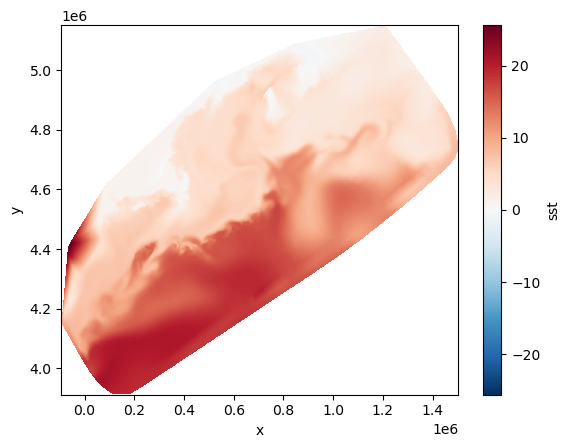

In [27]:
ds_out.sst.plot()

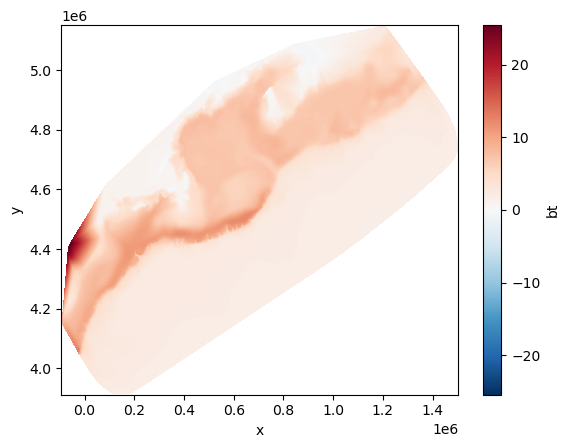

In [30]:
ds_out.bt.plot()